In [1]:
import re, os, sys, pickle, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame
import pyfaidx
from ete3 import Tree, NodeStyle, TreeStyle, TextFace
import skbio

numpy.random.seed(7)

### Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [3]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

### Plotting setup

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

Ignore deprecation warning:

In [5]:

# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

# Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# Runs of 100kb windows that show the same categorization of populations into low pi and non-low pi

In [7]:
abs_low_window_chrX_df = pandas.read_hdf(results_dir / 'abs_low_window_chrX_df.hdf')

In [8]:
# def bits2int(bitlist):
#     out = 0
#     for bit in map(int, bitlist):
#         out = (out << 1) | bit
#     return out

def bit_str(bitlist):
    return ''.join([str(int(x)) for x in bitlist])

def bit_vals(df):
    group = df.sort_values(by=['pop_label'])
    if numpy.isnan(group.is_low_region).any():
        bitval = numpy.nan
        nr_pop_low = numpy.nan
    else:
        # bitval = bits2int(group.is_low_region)
        bitval = bit_str(group.is_low_region)
        nr_pop_low = group.is_low_region.sum()
    return DataFrame({'bitval': [bitval], 'nr_pop_low': [nr_pop_low]})
    
cols = ['chrom', 'start', 'end']
df = (abs_low_window_chrX_df
      .groupby(cols)
      .apply(bit_vals)
      .reset_index(level=cols)
      .assign(sgm_run = 1, 
              sgm_run_id = lambda df: (df.bitval != df.bitval.shift()).cumsum())
       .reset_index(drop=True)
      )
#print(df3.loc[df3.nr_pop_low > 1].head())

cols = ['sgm_run_id']
nj_tree_windows_df = df.join(df.groupby(cols)['sgm_run'].sum(), on=cols, rsuffix='_length')

In [9]:
nj_tree_windows_df.loc[(nj_tree_windows_df.nr_pop_low > 20) & (nj_tree_windows_df.sgm_run_length > 3)].head()

,chrom,start,end,bitval,nr_pop_low,sgm_run,sgm_run_id,sgm_run_length
767,X,76700000,76800000,1001001101001000000000000000000010000100000000...,30,1,424,4
768,X,76800000,76900000,1001001101001000000000000000000010000100000000...,30,1,424,4
769,X,76900000,77000000,1001001101001000000000000000000010000100000000...,30,1,424,4
770,X,77000000,77100000,1001001101001000000000000000000010000100000000...,30,1,424,4
1009,X,100900000,101000000,0000000000000001000110000010011000000000100000...,27,1,564,5


In [10]:
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

nj_tree_regions_df = (nj_tree_windows_df
          .groupby(['chrom', 'sgm_run_id'])
          .aggregate({'start': 'min', 'end': 'max', 'sgm_run': 'sum', 
                      'nr_pop_low': ident_scalar, 'sgm_run_length': ident_scalar})
          .reset_index(level=['chrom', 'sgm_run_id'])
     )
#nj_tree_regions_df.loc[(nj_tree_regions_df.sgm_run_length >= 3) & (nj_tree_regions_df.nr_pop_low >= 20)]
nj_tree_regions_df.loc[(nj_tree_regions_df.sgm_run_length >= 3) & (nj_tree_regions_df.nr_pop_low >= 10)]

,chrom,sgm_run_id,end,nr_pop_low,sgm_run,start,sgm_run_length
7,X,8,4400000,10,3,4100000,3
24,X,25,10700000,13,5,10200000,5
139,X,140,28300000,14,3,28000000,3
187,X,188,37500000,32,3,37200000,3
200,X,201,41800000,14,4,41400000,4
214,X,215,43500000,21,3,43200000,3
226,X,227,46700000,12,4,46300000,4
238,X,239,49000000,16,3,48700000,3
361,X,362,67900000,18,3,67600000,3
379,X,380,71600000,12,3,71300000,3


In [11]:
nj_tree_regions_df.loc[(nj_tree_regions_df.sgm_run_length >= 3) & (nj_tree_regions_df.nr_pop_low == 0)]

,chrom,sgm_run_id,end,nr_pop_low,sgm_run,start,sgm_run_length
0,X,1,3100000,0,31,0,31
38,X,39,13900000,0,12,12700000,12
107,X,108,24000000,0,3,23700000,3
147,X,148,29800000,0,3,29500000,3
155,X,156,33400000,0,22,31200000,22
197,X,198,40400000,0,7,39700000,7
231,X,232,47500000,0,3,47200000,3
233,X,234,48300000,0,3,48000000,3
261,X,262,53000000,0,16,51400000,16
309,X,310,62500000,0,44,58100000,44




# World map with sweep sharing

Get population center locations:

In [12]:
with open(str(results_dir / 'pop_locations.pkl'), 'rb') as f:
    pop_locations = pickle.load(f)

World map:

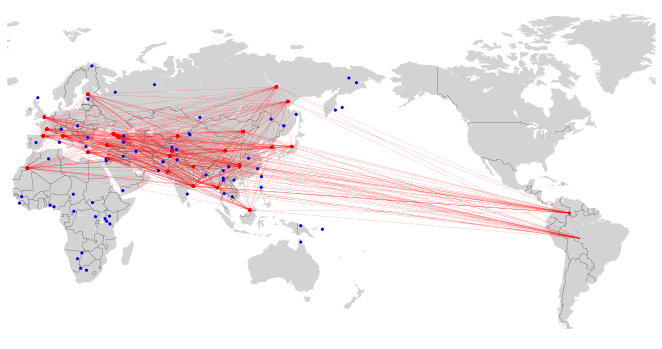

In [13]:


#df = abs_low_window_chrX_df.assign(is_low_region = lambda df: (df.islow) & (df.run >= min_run_length))

#start, end = 100900000, 101400000
#start, end = 129800000, 130200000
#start, end = 28000000, 28300000
start, end = 37200000, 37500000
df = abs_low_window_chrX_df
table = (df
         .loc[(df.start >= start) & (df.start < end)]
         .pivot(index='start', columns='population', values='is_low_region')
        )
geo_edges = list()
map_population_coords = list()
for i, a in enumerate(table.columns.values):
    map_population_coords.append(pop_locations[a])
    for j, b in enumerate(table.columns.values):
        if j > i:
            lat1, long1 = pop_locations[a]
            lat2, long2 = pop_locations[b]
            shared_low_pi_windows = sum(table[a].values & table[b].values)
            if shared_low_pi_windows == (end - start)/100000:
                geo_edges.append(((long1, lat1, long2, lat2), shared_low_pi_windows))

#ax = plt.hist(list(zip(*geo_edges))[1])

plt.close()
fig = plt.figure(figsize=(12,6), frameon=False)

# back to remove border around map
ax = fig.add_subplot(111)
ax.axis('off')

# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon are the lat/lon values of the lower 
# left and upper right corners of the map. resolution = 'c' is crude, l is low, 
# i is intermediate, h is high, f is full

m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=85,
            llcrnrlon=-20,urcrnrlon=340,resolution='c', suppress_ticks=True)

# m = Basemap(projection='mill',
#             urcrnrlon=180, 
#             urcrnrlat=85,
#             llcrnrlon=-180,
#             llcrnrlat=-60,
#             resolution='c', # 'c' is crude, l is low, i is intermediate, h is high, f is full
#             suppress_ticks=True)

m.fillcontinents(color='lightgrey',lake_color='white', zorder=1)
m.drawcountries(linewidth=0.2, linestyle='solid', color='black')

pop_x_coords_connected = list()
pop_y_coords_connected = list()
for (long1, lat1, long2, lat2), shared_low_windows in geo_edges:

    if long1 < -20:
        long1 = 360 + long1 
    if long2 < -20:
        long2 = 360 + long2
    
    x1, y1 = m(long1, lat1)
    x2, y2 = m(long2, lat2)    
    pop_x_coords_connected.append(x1)
    pop_y_coords_connected.append(y1)    
    #plt.plot([x1, x2], [y1, y2], color='red', linewidth=0.2, alpha=shared_low_windows/50)
    plt.plot([x1, x2], [y1, y2], color='red', linewidth=0.1)

pop_x_coords, pop_y_coords = zip(*[m(long, lat) for lat, long in map_population_coords])

#z = list(range(len(x)))
scatter = m.scatter(pop_x_coords, pop_y_coords, #c=z, 
                    s=10,
                    zorder=5, cmap='Reds', edgecolor='none')

scatter = m.scatter(pop_x_coords_connected, pop_y_coords_connected, color='red', #c=z, 
                    s=10,
                    zorder=5, cmap='Reds', edgecolor='none')

        
# # Add colorbar         x   y    width height
# cbaxes = fig.add_axes([0.7, 0.2, 0.2, 0.2], visible=False) 
# cb = m.colorbar(scatter, ax=cbaxes)
# cb.outline.set_color('none')
# #cb.outline.set_linewidth(2)
plt.savefig(str(figures_dir / "sweep_worldmap_{}_{}.pdf".format(start, end)))
plt.show()

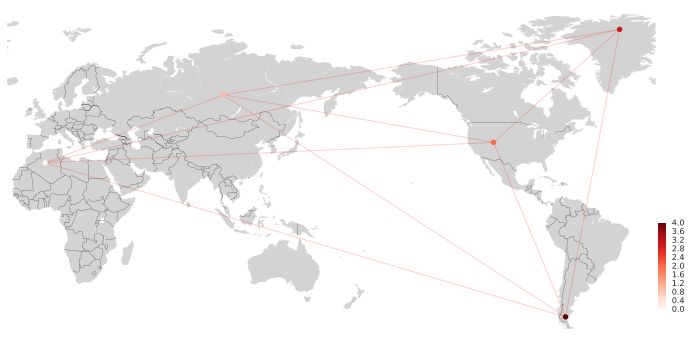

In [14]:
plt.close()
fig = plt.figure(figsize=(12,6), frameon=False)

# back to remove border around map
ax = fig.add_subplot(111)
ax.axis('off')

# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon are the lat/lon values of the lower 
# left and upper right corners of the map. resolution = 'c' is crude, l is low, 
# i is intermediate, h is high, f is full

m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=85,
            llcrnrlon=-20,urcrnrlon=340,resolution='c', suppress_ticks=True)

m.fillcontinents(color='lightgrey',lake_color='white', zorder=1)

m.drawcountries(linewidth=0.2, linestyle='solid', color='black')

long_lat_pairs = list(zip([1, 100, 250, 320, 290], [30, 60, 40, 80, -50]))

x_y_pairs = [m(*p) for p in long_lat_pairs]

for x1, y1 in x_y_pairs:
#    plt.plot(x1, y1, marker='o', color='red')
    for x2, y2 in x_y_pairs:
        plt.plot([x1, x2], [y1, y2], color='red', linewidth=1, alpha=0.1)

x, y = zip(*x_y_pairs)
z = list(range(len(x)))
scatter = m.scatter(x, y, c=z, s=30, zorder=5, cmap='Reds', edgecolor='none')

        
# Add colorbar         x   y    width height
cbaxes = fig.add_axes([0.7, 0.2, 0.2, 0.2], visible=False) 
cb = m.colorbar(scatter, ax=cbaxes)
cb.outline.set_color('none')
#cb.outline.set_linewidth(2)

plt.show()

# Sequence distance (NJ) between putative sweeps

### Build/load indexes from the fasta files:

In [15]:
file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), strict_bounds=True, one_based_attributes=False)

Code for construction of nj trees for regions of X:

In [16]:
def jc(seq1, seq2):
    assert len(seq1) == len(seq2)
    tot, diff = 0, 0
    for x, y in zip(seq1, seq2):
        if x in 'ATCG' and y in 'ATCG':
            if x != y:
                diff += 1
            tot += 1    
    if diff:
        distance = -3/4 * math.log(1 - 4/3 * diff/tot)
    else:
        distance = 0.0
    return distance

def dist_matrix(seq_list):
    n = len(seq_list)
    mat = numpy.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            mat[i][j] = jc(seq_list[i], seq_list[j])
            mat[j][i] = mat[i][j]
    return mat

def dist(seq1, seq2_list):
    n = len(seq_list)
    mat = numpy.zeros((n, n))
    
    upper_trag_idx = list(zip(*numpy.triu_indices(n, k=1)))
    seq_pairs = [(seq_list[i], seq_list[j]) for i, j in upper_trag_idx]
    jc_distances = dview.map_sync(jc, *zip(*seq_pairs))
    for (i, j), d in zip(upper_trag_idx, jc_distances):
        mat[i][j] = d
        mat[j][i] = mat[i][j]
#     for i in range(n):
#         for j in range(i, n):
#             mat[i][j] = jc(seq_list[i], seq_list[j])
#             mat[j][i] = mat[i][j]

    return mat

def nj_newick(start, end):
    start, end = int(start), int(end)
    seq_list = list()
    name_list = list()
    for name in file_index:
        seq_list.append(file_index[name]['X'][start:end].seq)
        name_list.append(name)
    
    dm = skbio.DistanceMatrix(dist_matrix(seq_list).tolist(), name_list)
    newick_str = skbio.tree.nj(dm, result_constructor=str)

    return newick_str

In [17]:
# #newick_str = nj_newick(10000000, 10000010)
# #fnewick_str = nj_newick(10500000, 10600000)
# newick_str = nj_newick(100900000, 101400000)
# ##newick_str = nj_newick(5e6, 6e6)

# newick_str = nj_newick(100900000, 101400000)
# with open('/Users/kmt/Desktop/tmp3.nex', 'w') as f:
#     print(newick_str + ';', file=f)

In [18]:
from ete3 import faces, AttrFace

region_colors = {'Africa': '#e41a1c', 'WestEurasia': '#377eb8', 'SouthAsia': '#4daf4a',
                 'CentralAsiaSiberia': '#984ea3', 'Oceania': '#ff7f00', 'EastAsia': '#ffff33', 'America': '#a65628'}

indiv2region = dict()
for region, indivs in regions.items():
    for i in indivs:
        indiv2region[i] = region

def layout(node):
    if node.is_leaf():
        r = indiv2region[node.name.replace('-A', '')]
        node.set_style(NodeStyle(size=10, fgcolor=region_colors[r]))
#         name_face = TextFace(node.name, fsize=30)
#         node.add_face(name_face, column=0)
    else:
        node.set_style(NodeStyle(size=0))

ts = TreeStyle()
ts.show_leaf_name = True
ts.mode = "c"
ts.layout_fn = layout
        

In [20]:
# start, end = 100900000, 101400000
# newick_str = nj_newick(start, end)
# with open(str(figures_dir / 'nj_chrX-{}-{}.nex'.format(start, end)), 'w') as f:
#     print(newick_str + ';', file=f)
# t = Tree(newick_str)
# t.render(str(figures_dir / "X-{}-{}.pdf".format(start, end)), tree_style=ts)
# t.render("%%inline", tree_style=ts)

In [ ]:
# start, end = 101000000, 101100000
# newick_str = nj_newick(start, end)
# with open(str(figures_dir / 'nj_chrX-{}-{}.nex'.format(start, end)), 'w') as f:
#     print(newick_str + ';', file=f)
# t = Tree(newick_str)
# t.render(str(figures_dir / "X-{}-{}.pdf".format(start, end)), tree_style=ts)
# t.render("%%inline", tree_style=ts) ;

In [ ]:
# start, end = 101400000, 101700000
# newick_str = nj_newick(start, end)
# with open(str(figures_dir / 'nj_chrX-{}-{}.nex'.format(start, end)), 'w') as f:
#     print(newick_str + ';', file=f)
# t = Tree(newick_str)
# t.render(str(figures_dir / "X-{}-{}.pdf".format(start, end)), tree_style=ts)
# t.render("%%inline", tree_style=ts)

In [ ]:
# start, end = 101600000, 101700000
# newick_str = nj_newick(start, end)
# with open(str(figures_dir / 'nj_chrX-{}-{}.nex'.format(start, end)), 'w') as f:
#     print(newick_str + ';', file=f)
# t = Tree(newick_str)
# t.render(str(figures_dir / "X-{}-{}.pdf".format(start, end)), tree_style=ts) ;

In [ ]:
# t.render("%%inline", tree_style=ts)

In [ ]:
#t.render(str(figures_dir / "tree3.pdf"), tree_style=ts) ; #, w=300, units="mm") ;